## Working with the dataset of [Sea ice drift tracks from the Distributed Network of autonomous buoys deployed during the Multidisciplinary drifting Observatory for the Study of Arctic Climate (MOSAiC) expedition 2019 - 2021](https://arcticdata.io/catalog/view/doi:10.18739/A2KP7TS83). 

Citation: Angela Bliss, Jennifer Hutchings, Philip Anderson, Philipp Anhaus, Hans Jakob Belter, Jørgen Berge, Vladimir Bessonov, Bin Cheng, Sylvia Cole, Dave Costa, Finlo Cottier, Christopher J Cox, Pedro R De La Torre, Dmitry V Divine, Gilbert Emzivat, Ying-Chih Fang, Steven Fons, Michael Gallagher, Maxime Geoffrey, Mats A Granskog, ... Guangyu Zuo. (2022). Sea ice drift tracks from the Distributed Network of autonomous buoys deployed during the Multidisciplinary drifting Observatory for the Study of Arctic Climate (MOSAiC) expedition 2019 - 2021. Arctic Data Center. [doi:10.18739/A2KP7TS83](https://arcticdata.io/catalog/view/doi:10.18739/A2KP7TS83).

This dataset has been aggregated as a ragged array dataset as part of the [Datasets module](https://cloud-drift.github.io/clouddrift/api.html#module-clouddrift.datasets) of the [clouddrift python library](https://github.com/Cloud-Drift/clouddrift). We show in this notebook how to load the dataset directly from clouddrift and showcase a couple of functionality of clouddrift.

In [2]:
import clouddrift as cd
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

In [3]:
# the dataset is part of the clouddrift library of dataset. 
# It can be loaded as a xarray Dataset for analysis in one line. If it is not
# present locally already it is downloaded and agregated:
ds = cd.datasets.mosaic()
ds

<xarray.Dataset>
Dimensions:                     (obs: 1926226, traj: 216)
Coordinates:
    time                        (obs) datetime64[ns] ...
    id                          (traj) object ...
Dimensions without coordinates: obs, traj
Data variables: (12/19)
    latitude                    (obs) float64 ...
    longitude                   (obs) float64 ...
    Deployment Leg              (traj) int64 ...
    DN Station ID               (traj) object ...
    IMEI                        (traj) object ...
    Deployment Date             (traj) datetime64[ns] ...
    ...                          ...
    Buoy Type                   (traj) object ...
    Manufacturer                (traj) object ...
    Model                       (traj) object ...
    PI                          (traj) object ...
    Data Authors                (traj) object ...
    count                       (traj) int64 ...

In [39]:
# the dataset is organized as a ragged array. As such we need to define the indices of each row which correspond to each sea ice track
row_index = np.insert(np.cumsum(ds["count"].values), 0, 0) # define row index

Text(0.5, 1.0, '2019W4')

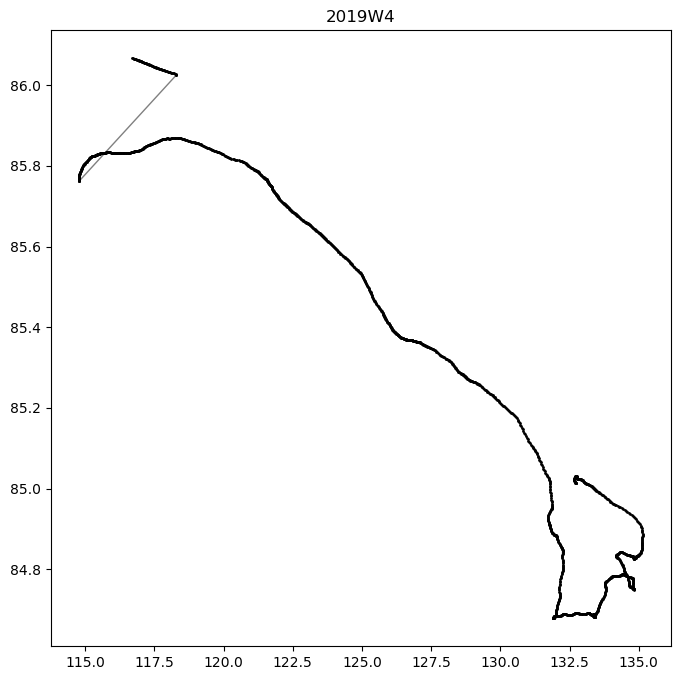

In [38]:
# we now plot the j-th track
j = 10
row = slice(row_index[j], row_index[j+1]) # define a slice for the j-th row
plt.figure(figsize=(8,8))
plt.plot(ds.longitude[row],ds.latitude[row],marker='o',markerfacecolor='k',markeredgecolor='none',markersize=2,linewidth=1,color=(0.5,0.5,0.5))
plt.title(ds.id[j].values)

We now show a couple of functionalities of clouddrift: calculation of Lagrangian velocity from positions with `velocity_from_position`, as well application of a function on each row of a ragged array thanks to `apply_ragged`:

In [40]:
from clouddrift.analysis import apply_ragged, velocity_from_position

In [47]:
# we calculate the zonal and meridional velocities from the Lagrangian tracks; the results will be in meter per unit of time provided (nanosecond)
# so let's multiply by 1e9 to get the speed in m/s
u,v = apply_ragged(velocity_from_position,[ds.longitude,ds.latitude,ds.time],ds["count"].values)

In [48]:
# add the u and v variables to dataset, not sure this is the best syntax?
ds["u"]=(['obs'],  1e9*u)
ds["v"]=(['obs'],  1e9*v)

In [49]:
speed = (ds.u**2+ds.v**2)**0.5

Text(0.5, 1.0, '2019W4')

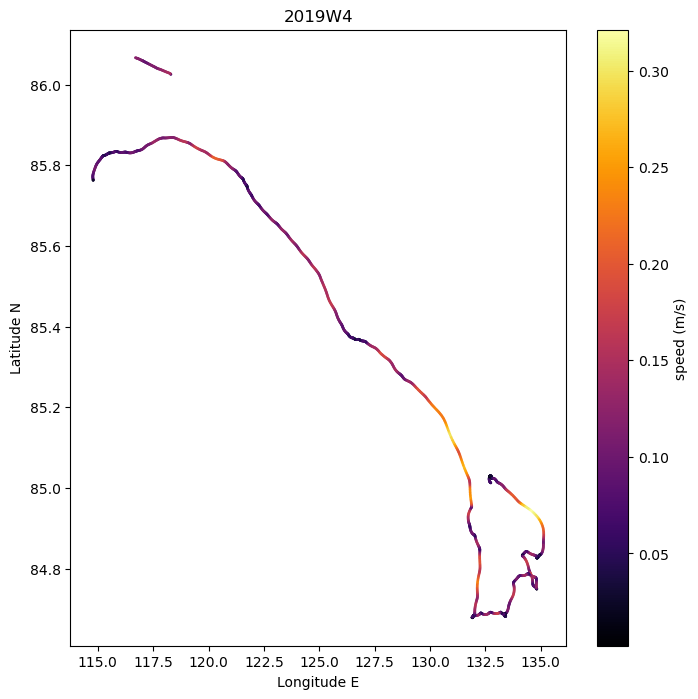

In [65]:
# Let's now replot the earlier plot but displaying the speed of the Lagrangian "drift" as a color along the track:
j = 10
sli = slice(row_index[j], row_index[j+1]) # define a slice for the j-th row

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
pcm1 = ax.scatter(ds.longitude[sli], ds.latitude[sli],s=1,c=speed[sli],cmap='inferno',edgecolor='face')
cb = fig.colorbar(pcm1,ax=ax)
cb.set_label('speed (m/s)')
ax.set_ylabel('Latitude N')
ax.set_xlabel('Longitude E')
ax.set_title(ds.id[j].values)

In [67]:
# this to test plotting with apply_ragged
# from clouddrift.sphere import sphere_to_plane
# x,y = apply_ragged(sphere_to_plane,[ds.longitude,ds.latitude],ds["count"].values,lon_origin=0,lat_origin=90);
# apply_ragged(plt.plot,[1e-3*x,1e-3*y],ds["count"].values,linewidth=0.5);

We can now plot a map of all trajectories. Here is one solution below but you may know a better projection for the area:

In [73]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111,projection=ccrs.NorthPolarStereo())
ax.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, zorder=1)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# the following application of apply_ragged crashes my kernel. Why? 
#apply_ragged(ax.plot,[ds.longitude,ds.latitude],ds["count"].values,transform=ccrs.PlateCarree());

for j in range(1,len(ds.traj)):
    row = slice(row_index[j], row_index[j+1])
    # plot each trajectory of a different color
    ax.plot(ds.longitude[row],ds.latitude[row],transform=ccrs.PlateCarree())
    # plot all trajectory color by speed
    #ax.scatter(ds.longitude[row], ds.latitude[row],s=1,c=speed[row],transform=ccrs.PlateCarree(),cmap='inferno',edgecolor='face')
